In [1]:
import os, sys
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OneHotEncoder,StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import RFE

from numpy import set_printoptions
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB



In [2]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [3]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from mlxtend.classifier import StackingClassifier
from kerastuner.tuners import RandomSearch
from scipy.stats import uniform

import numpy as np

In [18]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{exps_dir}/feature1/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0, 1: 1.0}

In [5]:
x_test.shape

(330, 42)

In [6]:
x_train.shape

(1022, 42)

In [7]:
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, BatchNormalization, Activation, add, MaxPooling1D, GlobalAveragePooling1D, Dense
from keras.models import Model
import keras.backend as K

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut."""
    filters1, filters2, filters3 = filters
    bn_axis=1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv1D(filters1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters3, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=2):
    """A block that has a conv layer at shortcut."""
    filters1, filters2, filters3 = filters
    bn_axis=1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv1D(filters1, 1, strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters3, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv1D(filters3, 1, strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

#### * Xây dựng model:

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform

# Định nghĩa không gian siêu tham số
param_dist = {'C': uniform(0.1, 10),
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))}

# Khởi tạo mô hình SVM
svm_model = SVC()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist, n_iter=5, scoring='accuracy', cv=5)
random_search.fit(x_train, y_train)

# In ra thông tin của mô hình SVM tốt nhất
print("Best SVM Hyperparameters:")
print(random_search.best_params_)
C=random_search.best_params_['C']
gamma=random_search.best_params_['gamma']
kernel=random_search.best_params_['kernel']

Best SVM Hyperparameters:
{'C': 8.264731282244044, 'gamma': 'scale', 'kernel': 'rbf'}


In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Định nghĩa không gian siêu tham số
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20],
}

# Khởi tạo mô hình Random Forest
rf_model = RandomForestClassifier()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=5, scoring='accuracy', cv=5)
random_search_rf.fit(x_train, y_train)

# In ra thông tin của mô hình Random Forest tốt nhất
print("Best Random Forest Hyperparameters:")
print(random_search_rf.best_params_)
n_estimators=random_search_rf.best_params_['n_estimators']
max_depth=random_search_rf.best_params_['max_depth']


Best Random Forest Hyperparameters:
{'n_estimators': 400, 'max_depth': 10}


In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform, randint

# Định nghĩa không gian siêu tham số cho Gradient Boosting
param_dist_gb = {'n_estimators': randint(50, 200),
                 'learning_rate': uniform(0.01, 0.1),
                 'max_depth': randint(3, 10),
                 'subsample': uniform(0.6, 0.4)}

# Khởi tạo mô hình Gradient Boosting
gb_model = GradientBoostingClassifier()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist_gb, n_iter=5, scoring='accuracy', cv=5)
random_search_gb.fit(x_train, y_train)

# In ra thông tin của mô hình Gradient Boosting tốt nhất
print("Best Gradient Boosting Hyperparameters:")
print(random_search_gb.best_params_)
best_gb_model = random_search_gb.best_estimator_
max_depthgb=random_search_gb.best_params_['max_depth']
learning_rate=random_search_gb.best_params_['learning_rate']
n_estimatorsgb=random_search_gb.best_params_['n_estimators']
subsample=random_search_gb.best_params_['subsample']

Best Gradient Boosting Hyperparameters:
{'learning_rate': 0.03518878812964028, 'max_depth': 7, 'n_estimators': 65, 'subsample': 0.9021760831081062}


In [11]:
from sklearn.tree import DecisionTreeClassifier

# Định nghĩa không gian siêu tham số cho Decision Tree
param_dist_dt = {'criterion': ['gini', 'entropy'],
                 'splitter': ['best', 'random'],
                 'max_depth': randint(3, 10),
                 'min_samples_split': randint(2, 20),
                 'min_samples_leaf': randint(1, 20)}

# Khởi tạo mô hình Decision Tree
dt_model = DecisionTreeClassifier()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_dist_dt, n_iter=5, scoring='accuracy', cv=5)
random_search_dt.fit(x_train, y_train)

# In ra thông tin của mô hình Decision Tree tốt nhất
print("Best Decision Tree Hyperparameters:")
print(random_search_dt.best_params_)
best_dt_model = random_search_dt.best_estimator_
criterion=random_search_dt.best_params_['criterion']
max_depthdt=random_search_dt.best_params_['max_depth']
min_samples_leaf=random_search_dt.best_params_['min_samples_leaf']
splitter=random_search_dt.best_params_['splitter']
min_samples_split=random_search_dt.best_params_['min_samples_split']


Best Decision Tree Hyperparameters:
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 13, 'min_samples_split': 15, 'splitter': 'best'}


In [14]:
from tensorflow.keras.optimizers import Adam
from keras.layers import ZeroPadding1D, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten
from keras.models import Model
from keras.layers import Input
lr=0.0001

def build_model(hp):
    input_shape =(42,1)
    x_input = Input(shape=input_shape)

    bn_axis = -1
    step=32
    # Sử dụng filters trong hàm build_resnet_model
    filters1 = [hp.Int('filter1', min_value=32, max_value=1024, step=step), hp.Int('filter2', min_value=32, max_value=1024, step=step), hp.Int('filter3', min_value=128, max_value=3096, step=128)]
    filters2 = [hp.Int('filter4', min_value=32, max_value=1024, step=step), hp.Int('filter5', min_value=32, max_value=1024, step=step), hp.Int('filter6', min_value=128, max_value=3096, step=128)]
    filters3 = [hp.Int('filter7', min_value=32, max_value=1024, step=step), hp.Int('filter8', min_value=32, max_value=1024, step=step), hp.Int('filter9', min_value=128, max_value=3096, step=128)]
    filters4 = [hp.Int('filter10', min_value=32, max_value=1024, step=step), hp.Int('filter11', min_value=32, max_value=1024, step=step), hp.Int('filter12', min_value=128, max_value=3096, step=128)]
    kernel_size = hp.Int('kernel_size', min_value=2, max_value=5, step=1)
    dense_units = hp.Int('dense_units', min_value=128, max_value=4096, step=128)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    x = ZeroPadding1D(padding=1)(x_input)
    x = Conv1D(64, 7, strides=2, padding='same', name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(kernel_size, strides=2)(x)

    # ResNet blocks
    x = conv_block(x, kernel_size, filters1, stage=2, block='a', strides=1)
    x = identity_block(x, kernel_size, filters1, stage=2, block='b')
    x = identity_block(x, kernel_size, filters1, stage=2, block='c')

    x = conv_block(x, kernel_size, filters2, stage=3, block='a')
    x = identity_block(x, kernel_size, filters2, stage=3, block='b')
    x = identity_block(x, kernel_size, filters2, stage=3, block='c')
    x = identity_block(x, kernel_size, filters2, stage=3, block='d')
    
    x = conv_block(x, kernel_size, filters3, stage=4, block='a')
    x = identity_block(x, kernel_size, filters3, stage=4, block='b')
    x = identity_block(x, kernel_size, filters3, stage=4, block='c')
    x = identity_block(x, kernel_size, filters3, stage=4, block='d')
    x = identity_block(x, kernel_size, filters3, stage=4, block='e')
    x = identity_block(x, 3, filters3, stage=4, block='f')

    x = conv_block(x, kernel_size, filters4, stage=5, block='a')
    x = identity_block(x, kernel_size, filters4, stage=5, block='b')
    x = identity_block(x, kernel_size, filters4, stage=5, block='c')
    # Repeat this pattern as needed

    # Ending layers
    x = GlobalAveragePooling1D()(x)
    #x = GlobalMaxPooling1D()(x)
    x = Flatten()(x)
    #x = Dense(1, activation='sigmoid', name='fc')(x)
    x = Dense(2, activation='softmax', name='fc1000')(x)

    # Create model
    model = Model(x_input, x, name='resnet50_1d')
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics='accuracy')

    return model

early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=30,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)

# Tạo đối tượng RandomSearch tuner
tuner = RandomSearch(build_model, objective='val_accuracy',  executions_per_trial=1, max_trials=15,directory='ResNet50')

tuner.search_space_summary()


# Tìm kiếm tham số tốt nhất
tuner.search(x_train, y_train, epochs=600, validation_data=(x_test, y_test),callbacks=[early_stopping,lr_scheduler])

# Lấy mô hình tốt nhất
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 15 Complete [01h 01m 53s]
val_accuracy: 0.7515151500701904

Best val_accuracy So Far: 0.7727272510528564
Total elapsed time: 1d 02h 25m 03s
Model: "resnet50_1d"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 42, 1)]      0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 44, 1)       0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv1D)                 (None, 22, 64)       512         ['zero_padding1d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 22

 res2c_branch2c (Conv1D)        (None, 10, 1664)     1066624     ['activation_8[0][0]']           
                                                                                                  
 bn2c_branch2c (BatchNormalizat  (None, 10, 1664)    40          ['res2c_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_2 (Add)                    (None, 10, 1664)     0           ['bn2c_branch2c[0][0]',          
                                                                  'activation_6[0][0]']           
                                                                                                  
 activation_9 (Activation)      (None, 10, 1664)     0           ['add_2[0][0]']                  
                                                                                                  
 res3a_bra

                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 5, 1280)      0           ['add_5[0][0]']                  
                                                                                                  
 res3d_branch2a (Conv1D)        (None, 5, 512)       655872      ['activation_18[0][0]']          
                                                                                                  
 bn3d_branch2a (BatchNormalizat  (None, 5, 512)      20          ['res3d_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_19 (Activation)     (None, 5, 512)       0           ['bn3d_branch2a[0][0]']          
          

 bn4c_branch2a (BatchNormalizat  (None, 3, 832)      12          ['res4c_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_28 (Activation)     (None, 3, 832)       0           ['bn4c_branch2a[0][0]']          
                                                                                                  
 res4c_branch2b (Conv1D)        (None, 3, 224)       745696      ['activation_28[0][0]']          
                                                                                                  
 bn4c_branch2b (BatchNormalizat  (None, 3, 224)      12          ['res4c_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activatio

                                                                                                  
 res4f_branch2c (Conv1D)        (None, 3, 1664)      374400      ['activation_38[0][0]']          
                                                                                                  
 bn4f_branch2c (BatchNormalizat  (None, 3, 1664)     12          ['res4f_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_12 (Add)                   (None, 3, 1664)      0           ['bn4f_branch2c[0][0]',          
                                                                  'activation_36[0][0]']          
                                                                                                  
 activation_39 (Activation)     (None, 3, 1664)      0           ['add_12[0][0]']                 
          

 add_15 (Add)                   (None, 2, 2560)      0           ['bn5c_branch2c[0][0]',          
                                                                  'activation_45[0][0]']          
                                                                                                  
 activation_48 (Activation)     (None, 2, 2560)      0           ['add_15[0][0]']                 
                                                                                                  
 global_average_pooling1d (Glob  (None, 2560)        0           ['activation_48[0][0]']          
 alAveragePooling1D)                                                                              
                                                                                                  
 flatten (Flatten)              (None, 2560)         0           ['global_average_pooling1d[0][0]'
                                                                 ]                                
          

In [15]:
best_trials = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
best_trials

{'filter1': 384,
 'filter2': 640,
 'filter3': 1664,
 'filter4': 512,
 'filter5': 896,
 'filter6': 1280,
 'filter7': 832,
 'filter8': 224,
 'filter9': 1664,
 'filter10': 192,
 'filter11': 64,
 'filter12': 2560,
 'kernel_size': 4,
 'dense_units': 768,
 'learning_rate': 0.001}

In [16]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "resnet50_1d"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 42, 1)]      0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 44, 1)       0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv1D)                 (None, 22, 64)       512         ['zero_padding1d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 22, 64)       256         ['conv1[0][0]']                  
                                                                                        

                                                                                                  
 res2c_branch2b (Conv1D)        (None, 10, 640)      983680      ['activation_7[0][0]']           
                                                                                                  
 bn2c_branch2b (BatchNormalizat  (None, 10, 640)     40          ['res2c_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_8 (Activation)      (None, 10, 640)      0           ['bn2c_branch2b[0][0]']          
                                                                                                  
 res2c_branch2c (Conv1D)        (None, 10, 1664)     1066624     ['activation_8[0][0]']           
                                                                                                  
 bn2c_bran

 activation_17 (Activation)     (None, 5, 896)       0           ['bn3c_branch2b[0][0]']          
                                                                                                  
 res3c_branch2c (Conv1D)        (None, 5, 1280)      1148160     ['activation_17[0][0]']          
                                                                                                  
 bn3c_branch2c (BatchNormalizat  (None, 5, 1280)     20          ['res3c_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_5 (Add)                    (None, 5, 1280)      0           ['bn3c_branch2c[0][0]',          
                                                                  'activation_15[0][0]']          
                                                                                                  
 activatio

                                                                                                  
 add_8 (Add)                    (None, 3, 1664)      0           ['bn4b_branch2c[0][0]',          
                                                                  'activation_24[0][0]']          
                                                                                                  
 activation_27 (Activation)     (None, 3, 1664)      0           ['add_8[0][0]']                  
                                                                                                  
 res4c_branch2a (Conv1D)        (None, 3, 832)       1385280     ['activation_27[0][0]']          
                                                                                                  
 bn4c_branch2a (BatchNormalizat  (None, 3, 832)      12          ['res4c_branch2a[0][0]']         
 ion)                                                                                             
          

 activation_37 (Activation)     (None, 3, 832)       0           ['bn4f_branch2a[0][0]']          
                                                                                                  
 res4f_branch2b (Conv1D)        (None, 3, 224)       559328      ['activation_37[0][0]']          
                                                                                                  
 bn4f_branch2b (BatchNormalizat  (None, 3, 224)      12          ['res4f_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_38 (Activation)     (None, 3, 224)       0           ['bn4f_branch2b[0][0]']          
                                                                                                  
 res4f_branch2c (Conv1D)        (None, 3, 1664)      374400      ['activation_38[0][0]']          
          

                                                                                                  
 activation_47 (Activation)     (None, 2, 64)        0           ['bn5c_branch2b[0][0]']          
                                                                                                  
 res5c_branch2c (Conv1D)        (None, 2, 2560)      166400      ['activation_47[0][0]']          
                                                                                                  
 bn5c_branch2c (BatchNormalizat  (None, 2, 2560)     8           ['res5c_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_15 (Add)                   (None, 2, 2560)      0           ['bn5c_branch2c[0][0]',          
                                                                  'activation_45[0][0]']          
          

In [19]:
rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
svm_model = SVC(C=C,kernel=kernel,gamma=gamma,probability=True)
dtc_model=DecisionTreeClassifier(criterion=criterion,max_depth=max_depthdt,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,splitter=splitter)
bg_model=GradientBoostingClassifier(n_estimators=n_estimatorsgb, learning_rate=learning_rate, max_depth=max_depthgb, subsample=subsample)
import numpy as np

rf_model.fit(x_train, y_train)
svm_model.fit(x_train, y_train)
dtc_model.fit(x_train, y_train)
bg_model.fit(x_train, y_train)

# Lấy dự đoán từ mỗi mô hình
predictions_model1 = best_model.predict(x_test)
predictions_model1 = np.argmax(predictions_model1, axis=1)
predictions_model2 = rf_model.predict(x_test)
predictions_model3 = svm_model.predict(x_test)
predictions_model4 = dtc_model.predict(x_test)
predictions_model5 = bg_model.predict(x_test)

results=[predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
for i in results:
    accuracy = accuracy_score(y_test, i)
    print("Ensemble Voting Accuracy", accuracy)


11/11 [==============================] - 4s 149ms/step
Ensemble Voting Accuracy 0.7787878787878788
Ensemble Voting Accuracy 0.7727272727272727
Ensemble Voting Accuracy 0.6909090909090909
Ensemble Voting Accuracy 0.8303030303030303
Ensemble Voting Accuracy 0.8121212121212121


In [20]:
def VotingClassifier(result):
    predictions_stack = np.vstack(result)
    majority_votes = np.sum(predictions_stack, axis=0) >= (predictions_stack.shape[0] / 2)
    return majority_votes.astype(int)
predictions = VotingClassifier([predictions_model1, predictions_model4, predictions_model5])

predictions.shape
accuracy = accuracy_score(y_test, predictions)

print("Ensemble Voting Accuracy", accuracy)

Ensemble Voting Accuracy 0.8272727272727273


In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.8272727272727273
Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.82      0.72        88
           0       0.93      0.83      0.88       242

    accuracy                           0.83       330
   macro avg       0.78      0.82      0.80       330
weighted avg       0.85      0.83      0.83       330



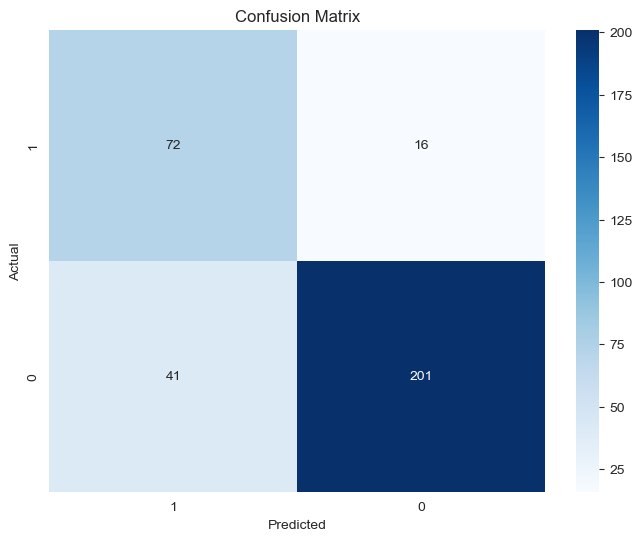

In [22]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [26]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = predictions
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: Y
----------------------------
True: Y
Predicted: Y
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: Y
----------------------------
True: Y
Predicted: Y
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: Y
----------------------------
True: Y
Predicted: Y
----------------------------


In [27]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 273 chiếm khoảng 82.72727272727273% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 72 chiếm khoảng 81.81818181818183% so với thực tế
